<img src="../style/img/vs265header.svg"/>

<h1 align="center">Lab 4 - Sparse, Distributed Representations</h1>

## Part 2 - Sparse Coding of Natural Images

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import utils.plotFunctions as pf
import utils.helperFunctions as hf

In the first part of lab 4 we generated our own data, so we knew exactly what the underlying generators of the data were. Here, we are going to attempt to learn the generators of a richer input ensemble: images of the natural world. We can't do this with the Foldiak sparse coding model because it only works with binary signals. Instead, we are going to learn a sparse coding dictionary as was originally described in Olshausen & Field's 1996 and 1997 papers. The algorithm we are going to use to compute sparse codes is Rozell's Locally Competitive Algorithm (LCA), as described in his 2008 paper. LCA is explained in detail in a course handout, read that before going forward!

The training data are obtained by extracting small image patches from whitened natural scenes, which one can think of as an idealization of the input provided by the LGN, as we discussed in class when learning about whitening transforms.

Run the algorithm using 64 output neurons on 8x8 pixel image patches. To do this you must:

* Fill in the LCA equations in the `lcaSparsify` function.

* Fill in the $\phi$ update learning rule in the `updatePhi` function.

Verify that you can reconstruct an image from the set of learned features and comment on what was learned as well as the parameters used.

The code cell below sets the parametrs for the sparse coding model. `numInputs` has been set to 64 to learn 8x8 pixel basis functions. This is not a hard constraint, so feel free to try out different patch sizes. You should also explore the effects of changing the `sparsityTradeoff` (i.e. $\lambda$) parameter. The LCA model has two key additional parameters: how long to perform inference is set by `numSteps` and the membrane integration time constant is set by the variable `tau` (i.e. $\tau$). A lower value for $\tau$ causes the LCA model to perform a more coarse estimate of the true dynamics and therefore come to an approximate solution in fewer steps. FInally, the `numOutputs` parameter establishes the overcompleteness of the model. What is the effect of changing the `numOutputs` and `sparsityTradeoff` parameters?

 <b>Notes:</b> The LCA model takes longer than Foldiak's model to run. Make sure you always set `numInputs` to a value that has an even square root. Finally, `numOutputs` should be assigned to a multiple of `numInputs`.

In [22]:
# General sparse coding parameters
numTrials = 1200 # Number of weight learning steps
numInputs = 64 # Number of input pixels, needs to have an even square root
numOutputs = 128 # Number of sparse coding neurons
sparsityTradeoff = 1.0  # YOUR CODE HERE # Lambda parameter that determines how sparse the model will be
batchSize = 500 # How many image patches to include in batch
eta = 0.08 # Learning rate

# LCA specific parameters
tau = 40 # LCA update time constant
numSteps = 40 # Number of iterations to run LCA

# Plot display parameters
displayInterval = 50 # How often to update display plots during learning

<IPython.core.display.Javascript object>


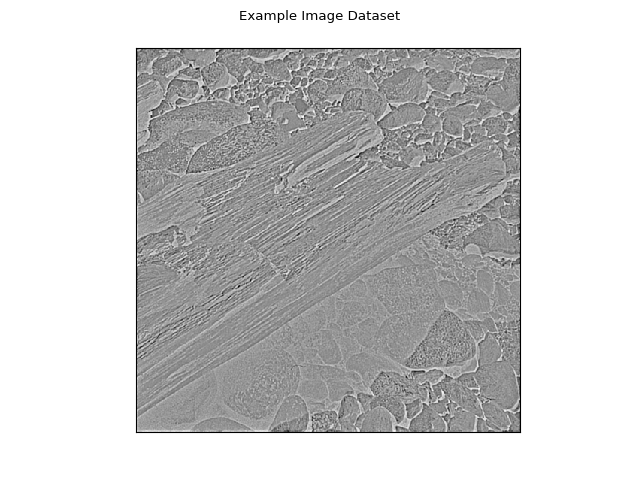

In [23]:
assert numInputs%np.sqrt(numInputs) == 0, (
    "numInputs must have an even square root.")

# Load images and view them
dataset = np.load("data/IMAGES.npy")
[pixelsCols, pixelsRows, numImages] = dataset.shape
numPixels = pixelsCols * pixelsRows
dataset = dataset.reshape(numPixels, numImages)
dataset /= np.sqrt(np.var(dataset)) # We want the dataset to have variance=1

# Note: Here you can index any image, or just delete the [:,0] part and plot all images
pf.plotDataTiled(dataset[:,0], "Example Image Dataset");

In [5]:

def lcaSparsify(data, phi, tau, sparsityTradeoff, numSteps):
    """
    Compute sparse code of input data using the LCA

    Parameters
    ----------
    data : np.ndarray of dimensions (numInputs, batchSize) holding a batch of image patches
    phi : np.ndarray of dimensions (numInputs, numOutputs) holding sparse coding dictionary
    tau : float for setting time constant for LCA differential equation
    sparsityTradeoff : float indicating Sparse Coding lambda value (also LCA neuron threshold)
    numSteps: int indicating number of inference steps for the LCA model
    
    Returns
    -------
    a : np.ndarray of dimensions (numOutputs, batchSize) holding thresholded potentials
    """
    b = phi.T @ data  # YOUR CODE HERE # Driving input
    gramian = phi.T @ phi - np.identity(int(phi.shape[1])) # Explaining away matrix
    u = np.zeros_like(b) # Initialize membrane potentials to 0
    for step in range(numSteps):
        a = hf.lcaThreshold(u, sparsityTradeoff) # Activity vector contains thresholded membrane potentials
        du = b - gramian @ a - u # YOUR CODE HERE # LCA dynamics define membrane update
        u = u + (1.0/tau) * du # Update membrane potentials using time constant
    return hf.lcaThreshold(u, sparsityTradeoff)

def lcaLearn(phi, patchBatch, sparseCode, learningRate):
    patchBatchRecon = phi @ sparseCode # YOUR CODE HERE # Reconstruct input using the inferred sparse code
    reconError = patchBatch - patchBatchRecon # YOUR CODE HERE # Error between the input and reconstruction
    dPhi = reconError @ sparseCode.T # YOUR CODE HERE # Weight update rule (dE/dPhi)
    phi = phi + learningRate * dPhi # Scale weight update by learning rate
    return (phi, reconError)

<IPython.core.display.Javascript object>


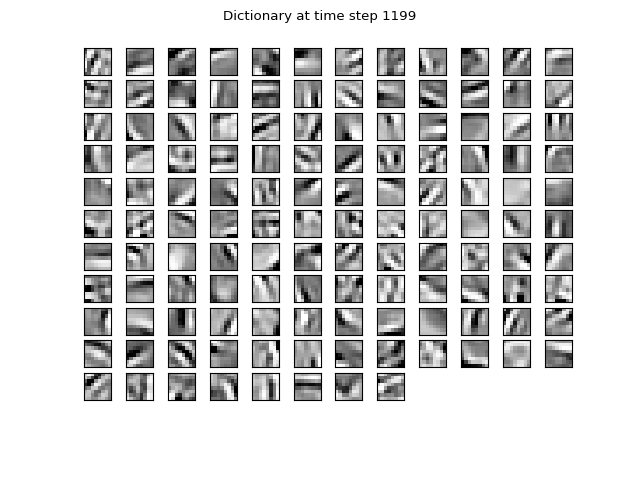

In [24]:
# Initialize some empty arrays to hold network summary statistics
percNonzero = np.zeros(numTrials)
energy = np.zeros(numTrials)
reconQuality = np.zeros(numTrials)

# Initialize Phi weight matrix with random values
phi = hf.l2Norm(np.random.randn(numInputs, numOutputs))

# Do sparse coding with LCA
prevFig = pf.plotDataTiled(phi, "Dictionary at time step 0", None)
for trial in range(numTrials):
    # Make batch of random image patches
    patchBatch = np.zeros((numInputs, batchSize))
    for batchNum in range(batchSize):
        patchBatch[:, batchNum] = hf.getRandomPatch(dataset, int(np.sqrt(numInputs)))

    # Compute sparse code for batch of image patches
    sparseCode = lcaSparsify(patchBatch, phi, tau, sparsityTradeoff, numSteps)
    
    # Update weights using inferred sparse code
    learningRate = eta / batchSize
    (phi, reconError) = lcaLearn(phi, patchBatch, sparseCode, learningRate)
    
    # Renormalize phi matrix
    phi = hf.l2Norm(phi)
    
    # Record some stats for plotting
    percNonzero[trial] = 100 * np.count_nonzero(sparseCode) / sparseCode.size
    energy[trial] = (np.mean(0.5 * np.sum(np.power(reconError, 2.0), axis=0))
        + sparsityTradeoff * np.mean(np.sum(np.abs(sparseCode), axis=0)))
    MSE = np.mean(np.power(reconError, 2.0))
    reconQuality[trial] = 10 * np.log(1**2 / MSE)
    
    if trial % displayInterval == 0:
        prevFig = pf.plotDataTiled(phi, "Dictionary at time step "+str(trial), prevFig)
    
# Plot learned dictionary
prevFig = pf.plotDataTiled(phi, "Dictionary at time step "+str(trial), prevFig)

<IPython.core.display.Javascript object>


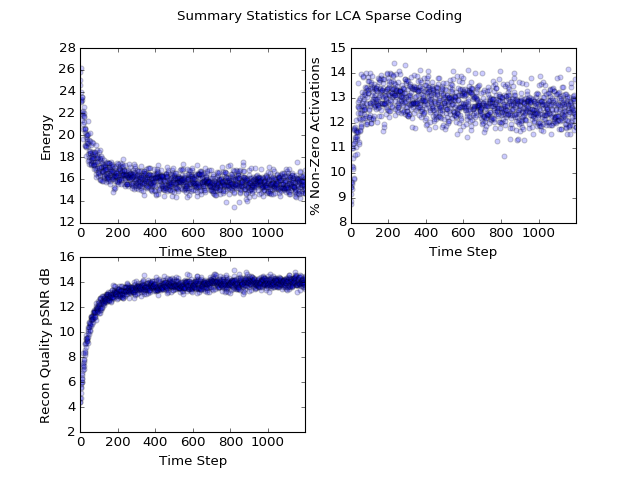

In [25]:
# Plot learning summary statistics
dataList = [energy, percNonzero, reconQuality]
labelList = ["Energy", "% Non-Zero Activations", "Recon Quality pSNR dB"]
title = "Summary Statistics for LCA Sparse Coding"
pf.makeSubplots(dataList, labelList, title)

<IPython.core.display.Javascript object>


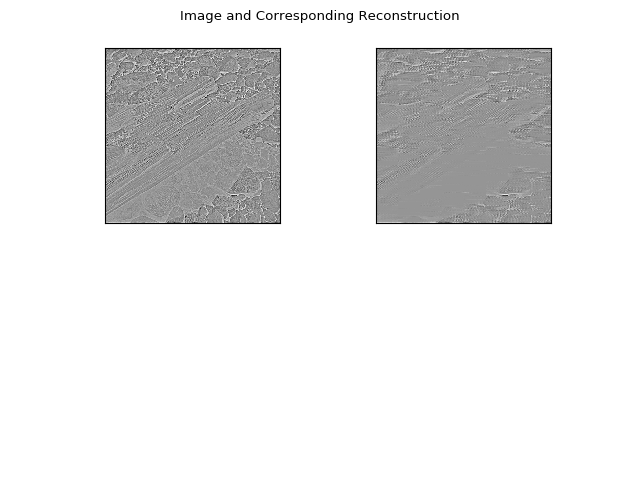

In [26]:
# Reconstruct an image
image = dataset[:,0]
imgPixels = image.size
numPatches = int(imgPixels/numInputs) # must divide evenly
patchBatch = image.reshape(numPatches, numInputs).T
sparseCode = lcaSparsify(patchBatch, phi, tau, sparsityTradeoff, numSteps)
reconBatch = phi @ sparseCode
reconImage = np.zeros(imgPixels)
reconImage = reconBatch.T.reshape(imgPixels)
imgAndRecon = np.vstack((image, reconImage)).T
pf.plotDataTiled(imgAndRecon, "Image and Corresponding Reconstruction");

<b>YOUR ANSWER HERE:</b> What is the effect of changing the sparsity tradeoff parameter, $\lambda$?

Changing the sparsity trade-off can change the structure of the learned dictionary elements in $\phi$. A sparsity coefficient much greater than unity means our algorithm will be biased toward low activations and ignore accurate reconstruction, so our basis functions will look more or less like noise. A small sparsity trade-off (close to zero) means we primarily minimize reconstruction error and ignore sparsity; this will give us the best image reconstruction in our training set but our basis functions will not depict true structure of the images.

Choosing a balanced sparsity coefficient of about 1 finds a medium between these two extremes, where the basis functions are gabor-like filters but image reconstruction quality.

Now try increasing the size of the network to 128 (or more) output neurons and decreasing the size to 32 (or less) output neurons. How do the learned features change as you modify the degree of overcompleteness?

<b>YOUR ANSWER HERE:</b> What is the effect modifying the number of output neurons?

Few output neurons only allows us to find an undercomplete basis and so we have blurrier images (high image reconstruction error) and a few simple filter shapes. By increasing the number of output neurons, we gradually see more diverse filter shapes (probably driven by the fact that sparsity forces the basis functions to avoid redundancy) which allows for better image reconstruction by providing sharper details.